# Project: Heart Attack Risk Prediction

**Goal** — to build a reproducible pipeline: from data loading and cleaning to model training and generating predictions.

**What needs to be done (work plan)**

* **Data loading**
* **Initial data quality check**
* **Preprocessing and cleaning**
* **EDA (Exploratory Data Analysis)**

  * Split features into groups
  * Build distributions, identify imbalances, outliers, and “suspicious” features
  * Perform correlation analysis (Phik), highlight strong relationships and draw conclusions about multicollinearity
* **Data preparation for modeling**
* **Model selection, training, and evaluation**
* **Final training and testing**
* **Interpretation**
* **Production application logic**


## Data Loading, Preparation, and EDA

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier

In [2]:
# Global Constants
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [3]:
df = pd.read_csv("../data/heart_train.csv")

### Data Preprocessing

**Let’s create a function to display the required characteristics (head, info, describe, missing values, duplicates, unique values)**

In [4]:
def look_data(x):
    print('------------- Original DataFrame (5 rows) -------------')
    display(x.head())
    print('')
    print('')
    print('------------- General information about the DataFrame -------------')
    display(x.info())
    print('')
    print('')
    print('------------- Number of missing values in the DataFrame -------------')
    display(x.isna().sum())
    print('')
    print('')
    print('------------- Number of explicit duplicates in the DataFrame -------------')
    display(x.duplicated().sum())
    print('')
    print('')
    print('------------- Descriptive statistics -------------')
    display(x.drop(columns=['id']).describe())
    print('')
    print('')
    print('------------- Check unique values in columns -------------')
    display(x.nunique())

In [5]:
# Displaying the required characteristics (head, info, describe, missing values, duplicates, unique values)
look_data(df)

------------- Original DataFrame (5 rows) -------------


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047




------------- General information about the DataFrame -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Hea

None



------------- Number of missing values in the DataFrame -------------


Unnamed: 0                           0
Age                                  0
Cholesterol                          0
Heart rate                           0
Diabetes                           243
Family History                     243
Smoking                            243
Obesity                            243
Alcohol Consumption                243
Exercise Hours Per Week              0
Diet                                 0
Previous Heart Problems            243
Medication Use                     243
Stress Level                       243
Sedentary Hours Per Day              0
Income                               0
BMI                                  0
Triglycerides                        0
Physical Activity Days Per Week    243
Sleep Hours Per Day                  0
Heart Attack Risk (Binary)           0
Blood sugar                          0
CK-MB                                0
Troponin                             0
Gender                               0
Systolic blood pressure  



------------- Number of explicit duplicates in the DataFrame -------------


np.int64(0)



------------- Descriptive statistics -------------


,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,...,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,...,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,...,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,...,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,...,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,...,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000




------------- Check unique values in columns -------------


Unnamed: 0                         8685
Age                                  77
Cholesterol                         282
Heart rate                           87
Diabetes                              2
Family History                        2
Smoking                               2
Obesity                               2
Alcohol Consumption                   2
Exercise Hours Per Week            7933
Diet                                  4
Previous Heart Problems               2
Medication Use                        2
Stress Level                         10
Sedentary Hours Per Day            7933
Income                             7808
BMI                                7933
Triglycerides                       772
Physical Activity Days Per Week       8
Sleep Hours Per Day                   8
Heart Attack Risk (Binary)            2
Blood sugar                         239
CK-MB                               679
Troponin                            340
Gender                                4


#### Results of the Initial Diagnostics (What the Function Showed)

**1) Size and data types**

* 8,685 rows, 28 columns.
* Types: 24 features of type `float`, 3 — `int`, 1 — `object` (`Gender`).
* Target variable: `Heart Attack Risk (Binary)` (binary).
* No duplicate `id` values.

**2) Duplicates**

* No explicit duplicates were found.

**3) Missing values**

A total of **243 missing values** were identified in the following columns:

`Diabetes`, `Family History`, `Smoking`, `Obesity`, `Alcohol Consumption`,
`Previous Heart Problems`, `Medication Use`, `Stress Level`, `Physical Activity Days Per Week`.

**Key comment:** the pattern of missing values appears **systematic rather than random** (not scattered across many columns). This requires further investigation.


**4) The `Gender` column has 4 unique values:**

In [6]:
df['Gender'].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

* **Valid values:** `Male`, `Female`
* **Suspicious values:** `'1.0'`, `'0.0'`

**Conclusion:** the values `'1.0'` and `'0.0'` likely indicate incorrect encoding or data corruption (two gender storage formats were mixed: textual and binary).

**5) `Unnamed: 0` — a technical index (not a feature); it was decided to remove it.**

#### Removing the `Unnamed: 0` Column

In [7]:
df.drop('Unnamed: 0', axis=1, inplace = True)

In [8]:
# Verification
df.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


#### Checking Missing Values and Their Relationship with Gender

**A list of columns with missing values (`cols_na`) has been formed**

In [9]:
# columns with missing values
cols_na = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Previous Heart Problems',
    'Medication Use',
    'Stress Level',
    'Physical Activity Days Per Week'
]

**Rows were filtered where:**

* `Gender` ∈ {`'0.0'`, `'1.0'`}
* and **all columns in `cols_na` contain NaN simultaneously**

In [10]:
filtered = df[
    df['Gender'].isin(['0.0', '1.0']) & 
    df[cols_na].isna().all(axis=1)
]

In [11]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243 entries, 16 to 8639
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              243 non-null    float64
 1   Cholesterol                      243 non-null    float64
 2   Heart rate                       243 non-null    float64
 3   Diabetes                         0 non-null      float64
 4   Family History                   0 non-null      float64
 5   Smoking                          0 non-null      float64
 6   Obesity                          0 non-null      float64
 7   Alcohol Consumption              0 non-null      float64
 8   Exercise Hours Per Week          243 non-null    float64
 9   Diet                             243 non-null    int64  
 10  Previous Heart Problems          0 non-null      float64
 11  Medication Use                   0 non-null      float64
 12  Stress Level             

**Distribution of `Gender` in the filtered table `filtered`**

In [12]:
filtered['Gender'].value_counts()

Gender
1.0    156
0.0     87
Name: count, dtype: int64

**Result:**

* `filtered` contains **exactly 243 rows**
* Gender distribution within them: `'1.0'` (156), `'0.0'` (87)
* and **in all of these rows**, missing values appear simultaneously across the block of columns `cols_na`.

**Additional observation on the unique values in the columns of the `filtered` table**

In [13]:
filtered.nunique()

Age                                 58
Cholesterol                          1
Heart rate                          63
Diabetes                             0
Family History                       0
Smoking                              0
Obesity                              0
Alcohol Consumption                  0
Exercise Hours Per Week              1
Diet                                 1
Previous Heart Problems              0
Medication Use                       0
Stress Level                         0
Sedentary Hours Per Day              1
Income                               1
BMI                                  1
Triglycerides                        1
Physical Activity Days Per Week      0
Sleep Hours Per Day                  1
Heart Attack Risk (Binary)           1
Blood sugar                        120
CK-MB                              210
Troponin                           103
Gender                               2
Systolic blood pressure             78
Diastolic blood pressure 

**Result**

In the identified 243 rows, many features have **only 1 unique value** (for example, *Cholesterol*, *Income*, *BMI*, *Exercise Hours Per Week*, etc.).

This does not resemble real measurements, as it is highly unlikely that all patients in this subset would have identical values across many features.


**Conclusion on missing values and their relationship with `Gender`:**

Rows that contain missing values and have `Gender = '0.0' / '1.0'` are not related to missing measurements, but rather to **corrupted records or an error during data generation (export)**. This conclusion is supported by the following observations:

* rows with missing values exactly совпадают with rows where gender is encoded using binary values (`'0.0'`, `'1.0'`), whereas in all other observations gender is represented by string values (`'Male'`, `'Female'`);
* in these rows, an entire block of medical and behavioral features is missing simultaneously;
* these rows show signs of **technical degradation**, since for a number of numerical features identical (constant) values are observed, indicating the absence of real measurements.

**Therefore, these observations cannot be considered reliable and are not recommended for use in model training.**

**Recommended action:**

* remove the 243 rows where `Gender` ∈ {'0.0', '1.0'} and all columns in the `cols_na` block contain NaN.

**Why removal is preferable to imputation:**

* these are not “random missing values,” but errors in row formation;
* imputing such NaNs with statistical values would mean “inventing data” and risking the introduction of artifacts.

#### Removing the 243 rows where `Gender` ∈ {'0.0', '1.0'} and all columns in the `cols_na` block contain `NaN`

In [14]:
df = df.drop(index=filtered.index).reset_index(drop=True)

In [15]:
# Verification
df.isna().sum()

Age                                0
Cholesterol                        0
Heart rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Heart Attack Risk (Binary)         0
Blood sugar                        0
CK-MB                              0
Troponin                           0
Gender                             0
Systolic blood pressure            0
Diastolic blood pressure           0
id                                 0
d

#### Analysis of Unique Values in Columns

Displaying the number of unique values per column

In [16]:
df.nunique()

Age                                  73
Cholesterol                         281
Heart rate                           71
Diabetes                              2
Family History                        2
Smoking                               2
Obesity                               2
Alcohol Consumption                   2
Exercise Hours Per Week            7932
Diet                                  3
Previous Heart Problems               2
Medication Use                        2
Stress Level                         10
Sedentary Hours Per Day            7932
Income                             7807
BMI                                7932
Triglycerides                       771
Physical Activity Days Per Week       8
Sleep Hours Per Day                   7
Heart Attack Risk (Binary)            2
Blood sugar                         224
CK-MB                               588
Troponin                            298
Gender                                2
Systolic blood pressure              91


**Binary numeric columns**

In [17]:
numeric_binary = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Previous Heart Problems',
    'Medication Use',
    'Heart Attack Risk (Binary)'
]

In [18]:
df[numeric_binary].apply(pd.Series.unique)

,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Previous Heart Problems,Medication Use,Heart Attack Risk (Binary)
0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


* **All features contain exactly two values: 0.0 and 1.0**
  This is correct and expected behavior for medical and behavioral features.

* The features are already in numeric format and do not require encoding.

* They can be directly used in machine learning models.

**Checking potential discrete features**

__Diet__

In [19]:
df['Diet'].unique()

array([1, 2, 0])

* There are only 3 unique values.

* Most likely, this is a categorical or ordinal feature (for example, diet type).

__Stress Level__

In [20]:
df['Stress Level'].unique()

array([ 8.,  9.,  6.,  3.,  7.,  1., 10.,  2.,  5.,  4.])

* Most likely, this represents a stress level scale (1–10).

__Physical Activity Days Per Week__

In [21]:
df['Physical Activity Days Per Week'].unique()

array([3., 2., 0., 5., 6., 4., 7., 1.])

* **8 unique values.**

* Most likely interpreted as the number of physical activity days per week.

__Sleep Hours Per Day__

In [22]:
df['Sleep Hours Per Day'].unique()

array([0.33333333, 0.83333333, 1.        , 0.        , 0.16666667,
       0.66666667, 0.5       ])

* The values appear to be the result of discretization/normalization (fractions of a day).


**Suspicious coincidences**

* The following features have the same number of unique values (**7,932**):

  * *Exercise Hours Per Week*
  * *Sedentary Hours Per Day*
  * *BMI*

* **What to check:**

  * correlations between these fields

### Exploratory Data Analysis

**Let’s create helper functions for EDA**

**Splitting features into continuous / discrete / categorical:**


**Categorical features**

* **Gender** — binary category (Male / Female)

* **Diet** — 3 categories (0 / 1 / 2), not a continuous variable


In [23]:
category = [
    'Gender',
    'Diet'
]

**Discrete numerical features**

These are features that:

* take a limited set of integer or discrete values,
* have a quantitative meaning,
* but are not continuous.


In [24]:
# Discrete numerical features
discrete = [
    'Stress Level',
    'Physical Activity Days Per Week',
    'Sleep Hours Per Day'
]

**Continuous numerical features**

All remaining numerical features that:

* have a wide range of values,
* or represent normalized continuous quantities,
* or correspond to real-world measurements.


In [25]:
# Continuous numerical features
continuous = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
]

**There are also binary features (excluding the target `Heart Attack Risk (Binary)`)**

In [26]:
binary = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Previous Heart Problems',
    'Medication Use'
]

In [27]:
label_dict = {
    # continuous numerical features
    'Age': [
        "Age distribution of patients",
        "Normalized age",
        "Number of observations"
    ],
    'Cholesterol': [
        "Cholesterol level distribution",
        "Normalized cholesterol level",
        "Number of observations"
    ],
    'Heart rate': [
        "Heart rate distribution",
        "Normalized heart rate",
        "Number of observations"
    ],
    'Exercise Hours Per Week': [
        "Distribution of exercise hours per week",
        "Normalized activity hours",
        "Number of observations"
    ],
    'Sedentary Hours Per Day': [
        "Distribution of sedentary hours per day",
        "Normalized sedentary hours",
        "Number of observations"
    ],
    'Income': [
        "Income level distribution",
        "Normalized income",
        "Number of observations"
    ],
    'BMI': [
        "Body Mass Index (BMI) distribution",
        "Normalized BMI",
        "Number of observations"
    ],
    'Triglycerides': [
        "Triglyceride level distribution",
        "Normalized triglyceride level",
        "Number of observations"
    ],
    'Blood sugar': [
        "Blood sugar level distribution",
        "Normalized blood sugar level",
        "Number of observations"
    ],
    'CK-MB': [
        "CK-MB level distribution",
        "Normalized CK-MB level",
        "Number of observations"
    ],
    'Troponin': [
        "Troponin level distribution",
        "Normalized troponin level",
        "Number of observations"
    ],
    'Systolic blood pressure': [
        "Systolic blood pressure distribution",
        "Normalized systolic blood pressure",
        "Number of observations"
    ],
    'Diastolic blood pressure': [
        "Diastolic blood pressure distribution",
        "Normalized diastolic blood pressure",
        "Number of observations"
    ],

    # discrete numerical features
    'Stress Level': [
        "Stress level distribution",
        "Stress level",
        "Number of observations"
    ],
    'Physical Activity Days Per Week': [
        "Distribution of physical activity days per week",
        "Number of days",
        "Number of observations"
    ],
    'Sleep Hours Per Day': [
        "Sleep duration distribution",
        "Sleep duration (normalized)",
        "Number of observations"
    ],

    # categorical features
    'Gender': [
        "Gender distribution of patients",
        "Gender",
        "Number of observations"
    ],
    'Diet': [
        "Diet type distribution",
        "Diet type",
        "Number of observations"
    ],

    # binary features
    'Diabetes': [
        "Distribution of diabetes presence",
        "Diabetes (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Family History': [
        "Distribution of family history",
        "Family history (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Smoking': [
        "Smoking status distribution",
        "Smoking (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Obesity': [
        "Distribution of obesity presence",
        "Obesity (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Alcohol Consumption': [
        "Alcohol consumption distribution",
        "Alcohol consumption (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Previous Heart Problems': [
        "Distribution of previous heart problems",
        "Previous problems (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Medication Use': [
        "Distribution of medication use",
        "Medication use (0 — no, 1 — yes)",
        "Number of observations"
    ],
    'Heart Attack Risk (Binary)': [
        "Heart attack risk distribution",
        "Risk (0 — low, 1 — high)",
        "Number of observations"
    ]
}

**EDA function**

In [28]:
def learn_data(df):
    def get_labels(col):
        vals = label_dict.get(col, None)
        if vals is None:
            return [f"Distribution: {col}", col, "Number of observations"]
        vals = list(vals) + [""] * (3 - len(vals))
        return vals[:3]

    for col in df.columns:
        if col == 'id':
            continue

        print(f"\n==== {col} ==== \n")
        title, xlabel, ylabel = get_labels(col)

        # Binary
        if col in binary:

            # bar chart (0/1 + NaN if present)
            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

            # pie chart
            counts = df[col].value_counts(dropna=False).sort_index()
            plt.figure(figsize=(5, 5))
            plt.pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                counterclock=False,
                wedgeprops={'edgecolor': 'white'}
            )
            pie_title = f"Class share — {xlabel}" if xlabel else f"Class share: {col}"
            plt.title(pie_title)
            plt.tight_layout()
            plt.show()

        # Continuous
        elif col in continuous:
            print(df[col].describe(), "\n")

            # Histogram
            plt.figure(figsize=(6, 4))
            plt.hist(df[col].dropna(), bins=50)
            plt.title(title if title else f"Histogram: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.tight_layout()
            plt.show()

            # Boxplot
            plt.figure(figsize=(4, 6))
            plt.boxplot(df[col].dropna(), vert=True, showmeans=True)
            plt.title(f"Boxplot: {col}")
            plt.ylabel(xlabel if xlabel else col)
            plt.tight_layout()
            plt.show()

        # Discrete
        elif col in discrete:
            print(df[col].describe(), "\n")

            # bar chart
            plt.figure(figsize=(6, 4))
            df[col].value_counts(dropna=False).sort_index().plot(
                kind="bar", grid=True
            )
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        # Categorical
        elif col in category:
            print(df[col].describe(), "\n")

            # bar chart
            counts = df[col].value_counts(dropna=False)
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

            # pie chart
            plt.figure(figsize=(5, 5))
            plt.pie(
                counts,
                labels=counts.index,
                autopct='%1.1f%%',
                startangle=90,
                counterclock=False,
                wedgeprops={'edgecolor': 'white'}
            )
            pie_title = f"Category share — {xlabel}" if xlabel else f"Category share: {col}"
            plt.title(pie_title)
            plt.tight_layout()
            plt.show()

        else:
            # Fallback for untagged columns
            print(df[col].describe(), "\n")
            counts = df[col].value_counts(dropna=False)

            # bar chart
            plt.figure(figsize=(6, 4))
            counts.plot(kind="bar")
            plt.title(title if title else f"Distribution: {col}")
            plt.xlabel(xlabel if xlabel else col)
            plt.ylabel(ylabel if ylabel else "Number of observations")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()



==== Age ==== 

count    8442.000000
mean        0.449008
std         0.232809
min         0.044944
25%         0.247191
50%         0.460674
75%         0.640449
max         0.853933
Name: Age, dtype: float64 



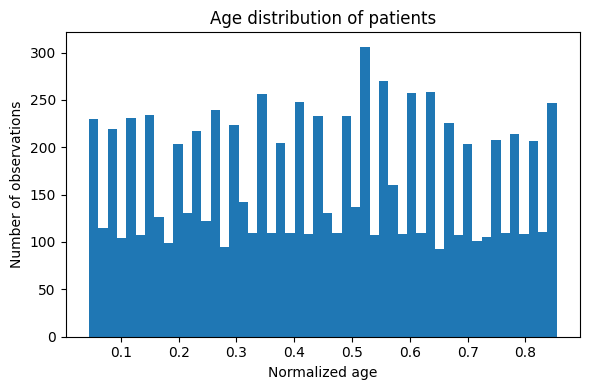

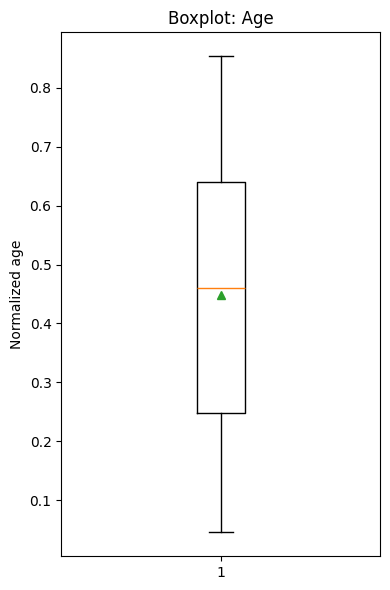


==== Cholesterol ==== 

count    8442.000000
mean        0.501108
std         0.288785
min         0.000000
25%         0.260714
50%         0.496429
75%         0.750000
max         1.000000
Name: Cholesterol, dtype: float64 



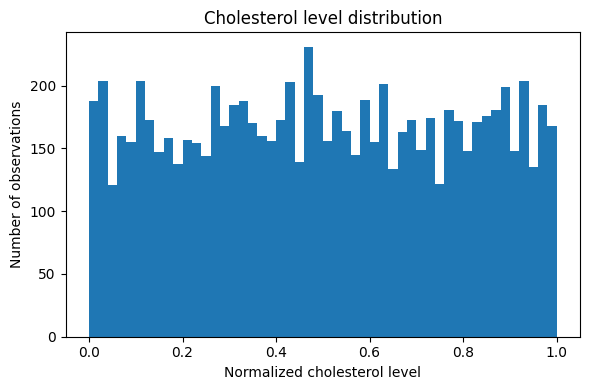

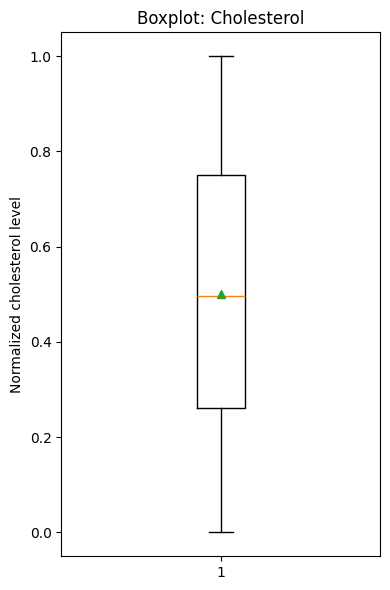


==== Heart rate ==== 

count    8442.000000
mean        0.050194
std         0.018442
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: Heart rate, dtype: float64 



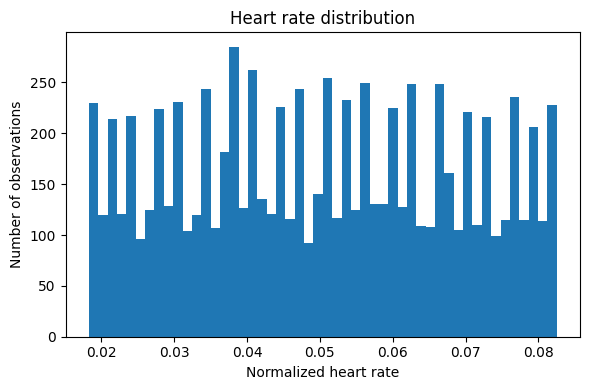

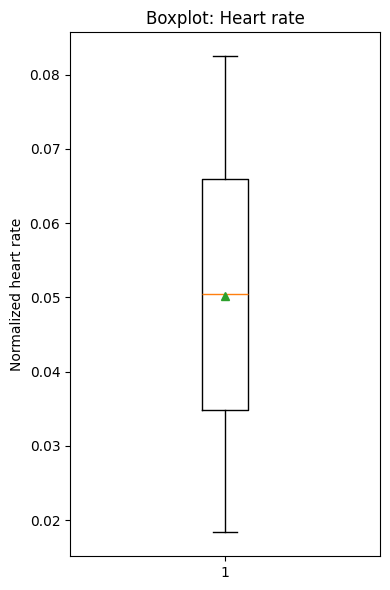


==== Diabetes ==== 



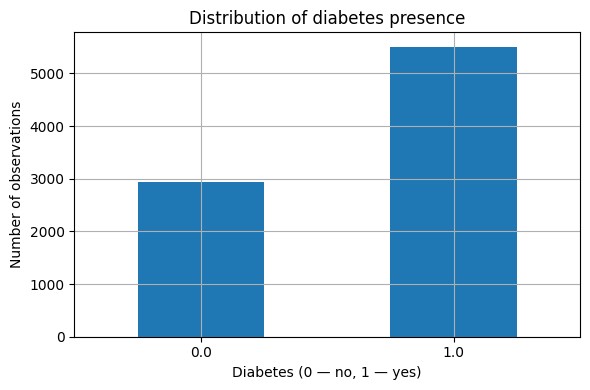

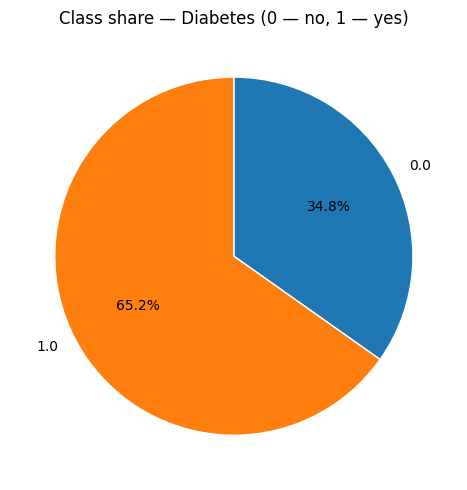


==== Family History ==== 



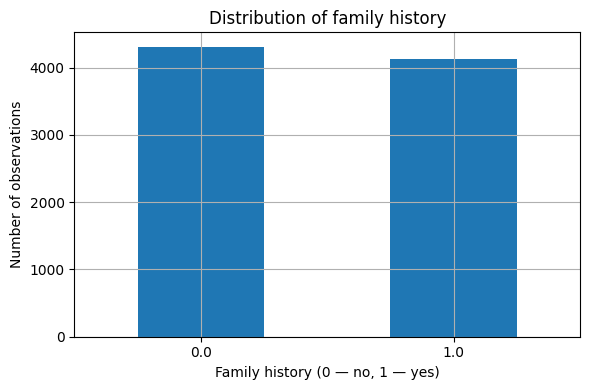

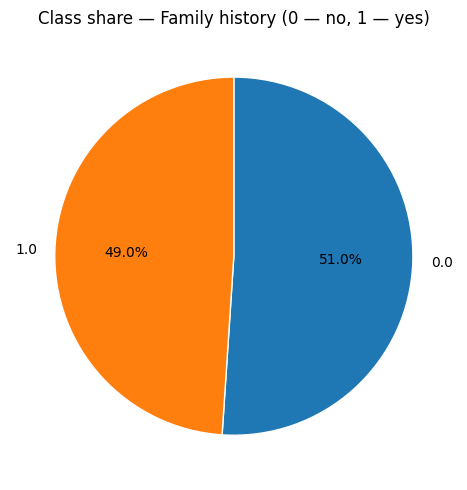


==== Smoking ==== 



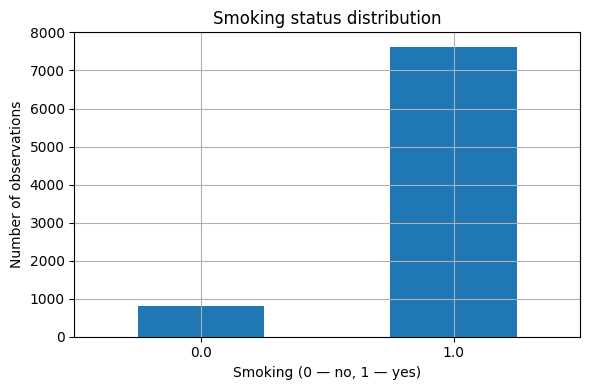

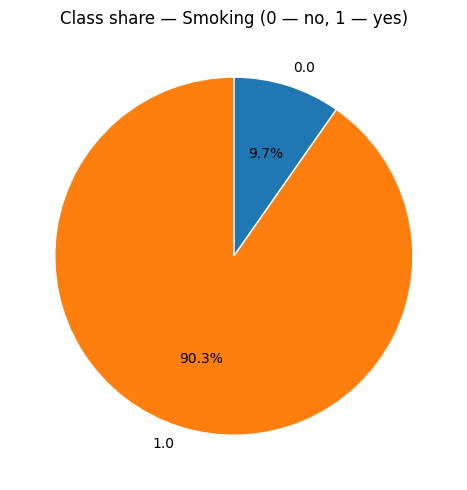


==== Obesity ==== 



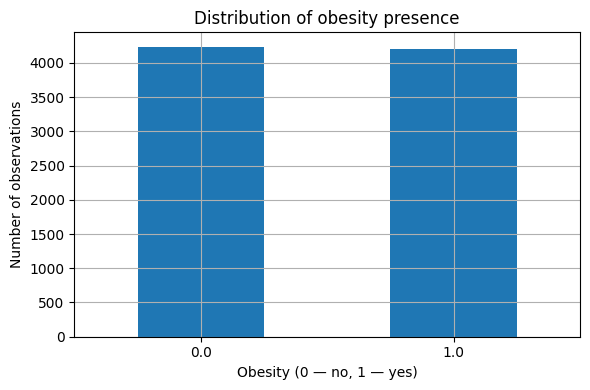

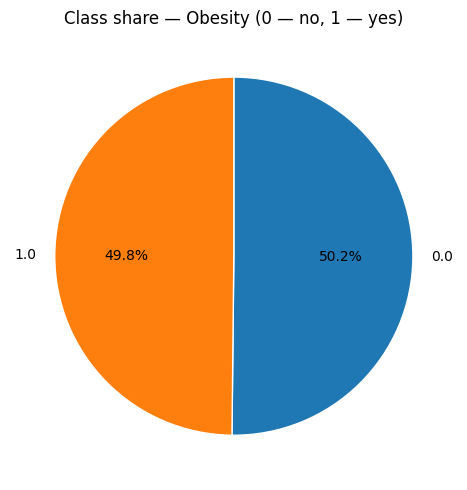


==== Alcohol Consumption ==== 



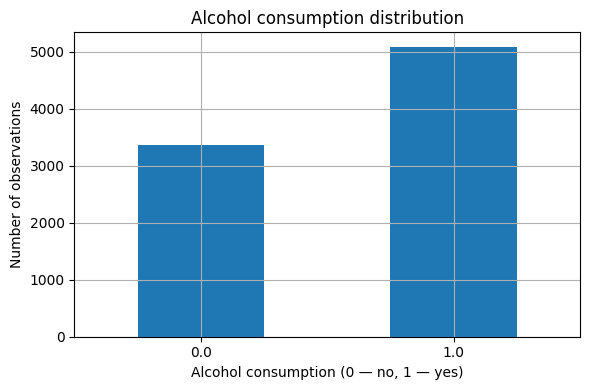

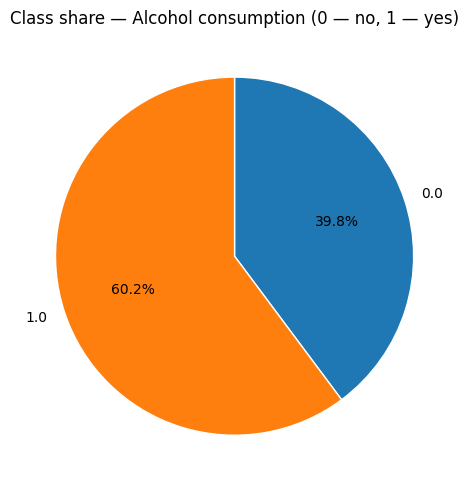


==== Exercise Hours Per Week ==== 

count    8442.000000
mean        0.503415
std         0.288881
min         0.000000
25%         0.253359
50%         0.508244
75%         0.754901
max         1.000000
Name: Exercise Hours Per Week, dtype: float64 



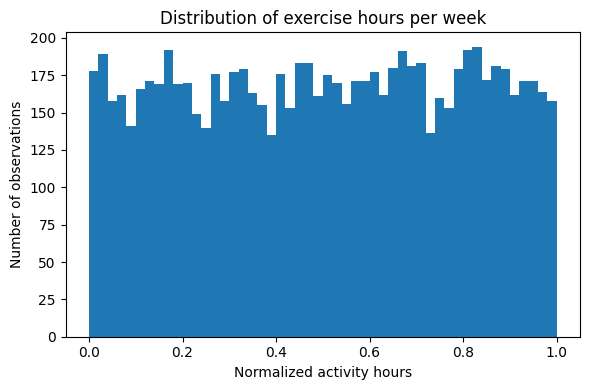

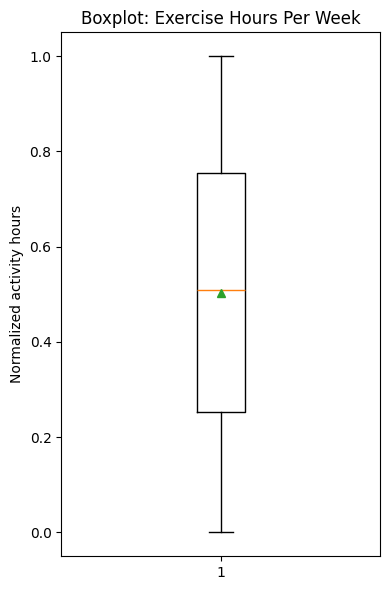


==== Diet ==== 

count    8442.000000
mean        1.001540
std         0.812981
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: Diet, dtype: float64 



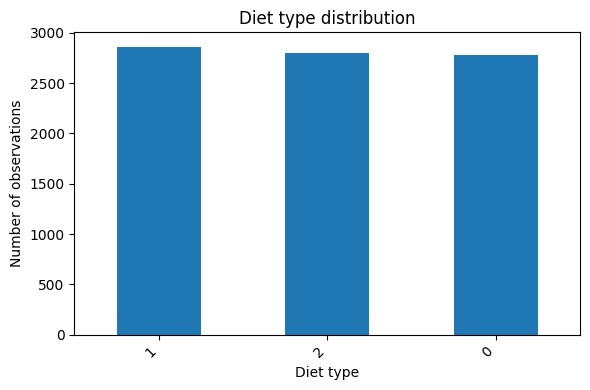

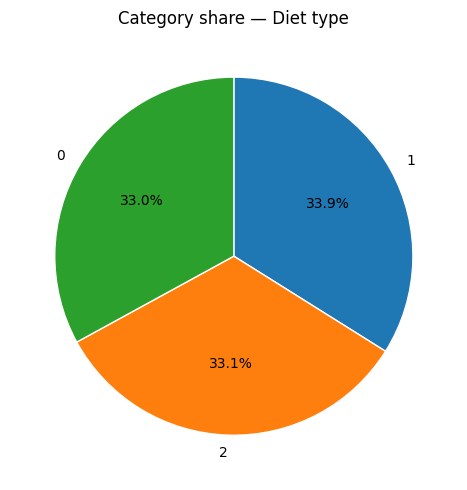


==== Previous Heart Problems ==== 



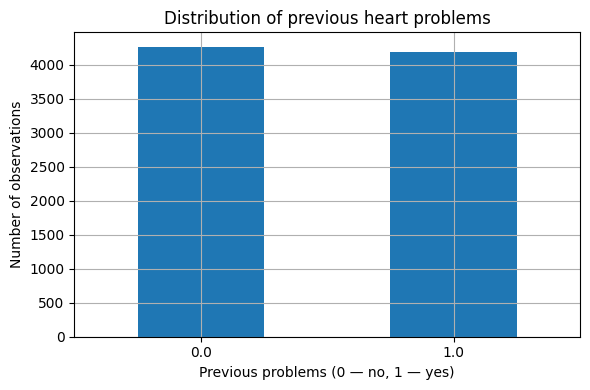

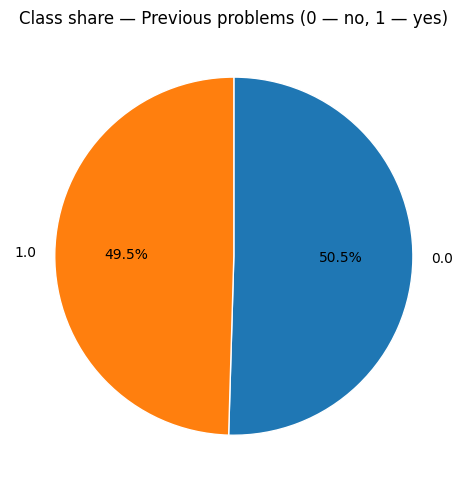


==== Medication Use ==== 



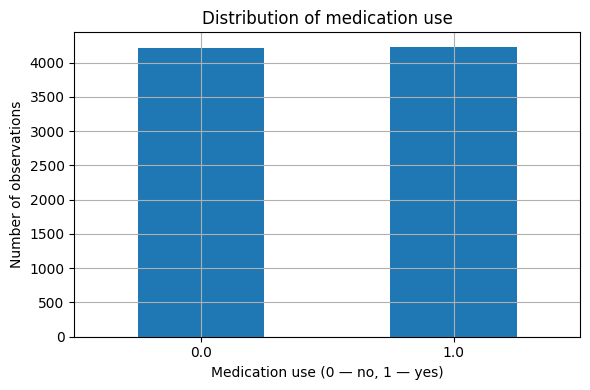

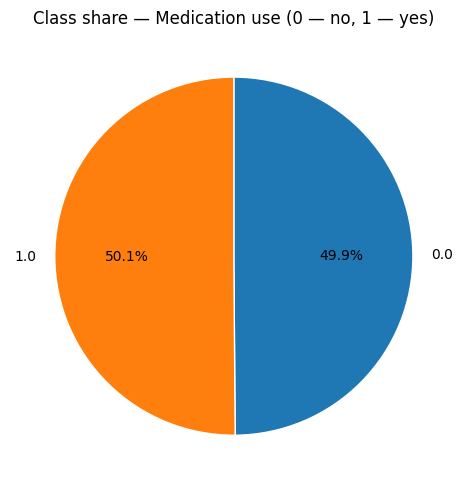


==== Stress Level ==== 

count    8442.000000
mean        5.493367
std         2.867862
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: Stress Level, dtype: float64 



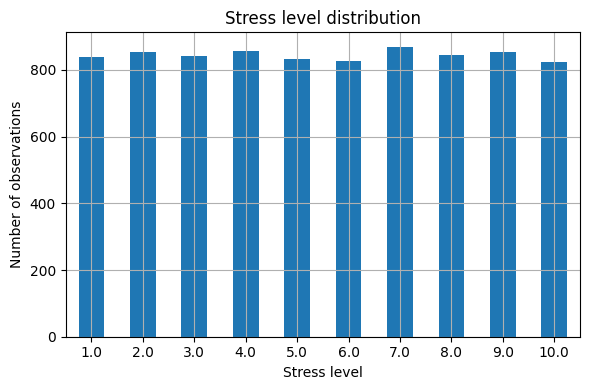


==== Sedentary Hours Per Day ==== 

count    8442.000000
mean        0.499142
std         0.289418
min         0.000000
25%         0.247650
50%         0.492734
75%         0.751047
max         1.000000
Name: Sedentary Hours Per Day, dtype: float64 



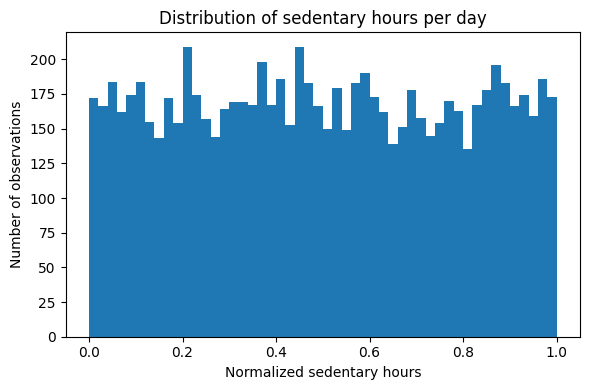

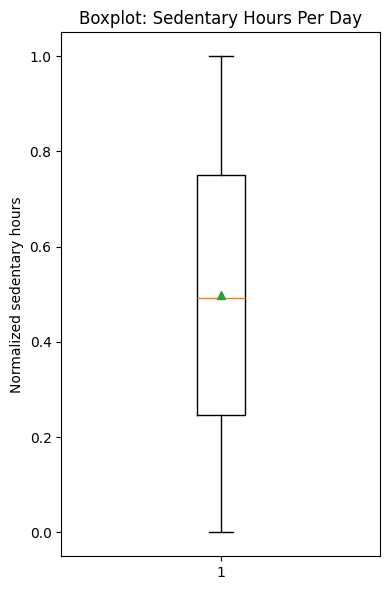


==== Income ==== 

count    8442.000000
mean        0.496089
std         0.288767
min         0.000000
25%         0.244591
50%         0.496052
75%         0.747603
max         1.000000
Name: Income, dtype: float64 



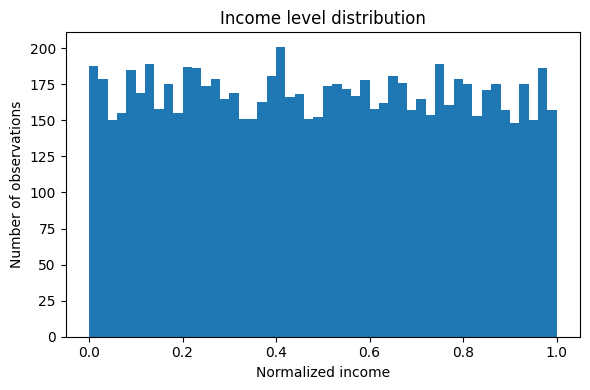

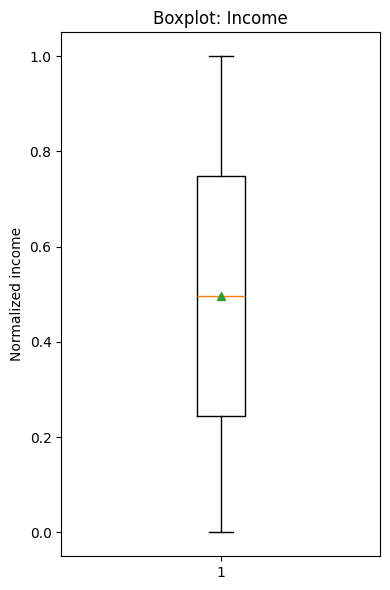


==== BMI ==== 

count    8442.000000
mean        0.496831
std         0.286599
min         0.000000
25%         0.247935
50%         0.490801
75%         0.744399
max         1.000000
Name: BMI, dtype: float64 



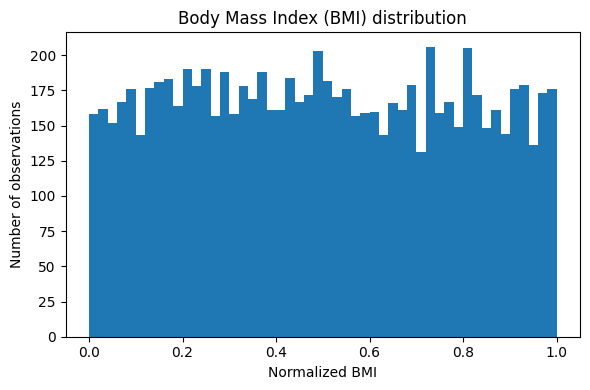

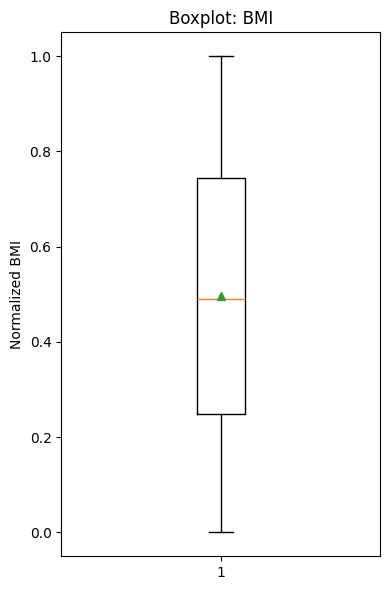


==== Triglycerides ==== 

count    8442.000000
mean        0.505539
std         0.290412
min         0.000000
25%         0.257143
50%         0.507792
75%         0.758442
max         1.000000
Name: Triglycerides, dtype: float64 



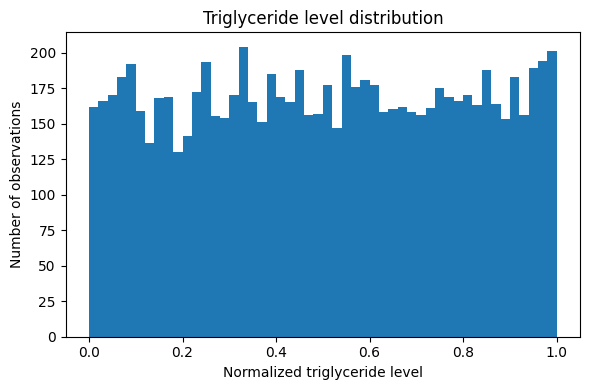

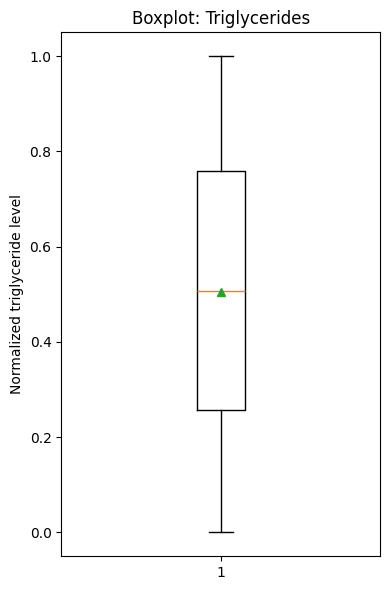


==== Physical Activity Days Per Week ==== 

count    8442.000000
mean        3.508292
std         2.281772
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max         7.000000
Name: Physical Activity Days Per Week, dtype: float64 



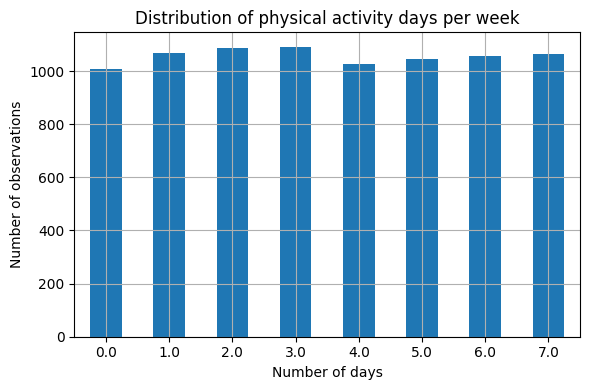


==== Sleep Hours Per Day ==== 

count    8442.000000
mean        0.503712
std         0.332749
min         0.000000
25%         0.166667
50%         0.500000
75%         0.833333
max         1.000000
Name: Sleep Hours Per Day, dtype: float64 



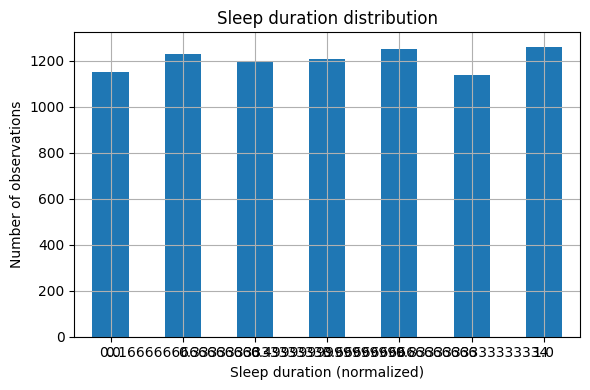


==== Heart Attack Risk (Binary) ==== 

count    8442.000000
mean        0.356906
std         0.479115
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Heart Attack Risk (Binary), dtype: float64 



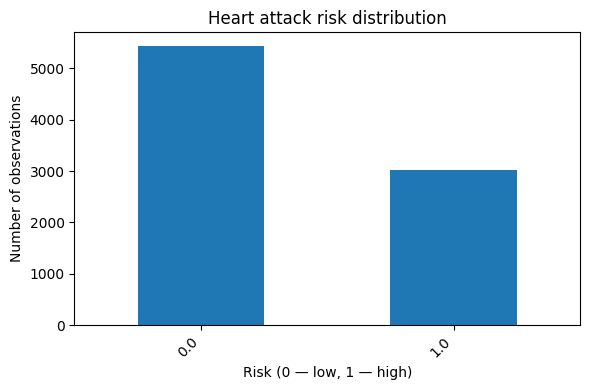


==== Blood sugar ==== 

count    8442.000000
mean        0.227998
std         0.074623
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: Blood sugar, dtype: float64 



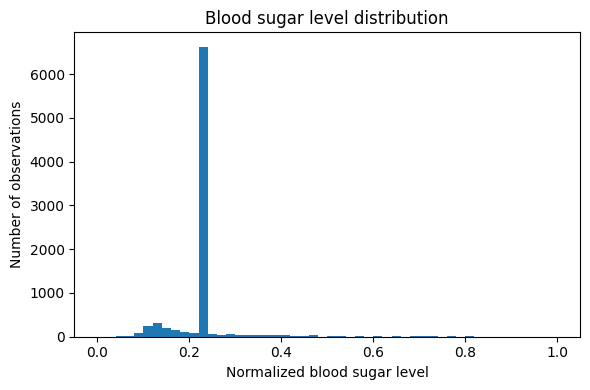

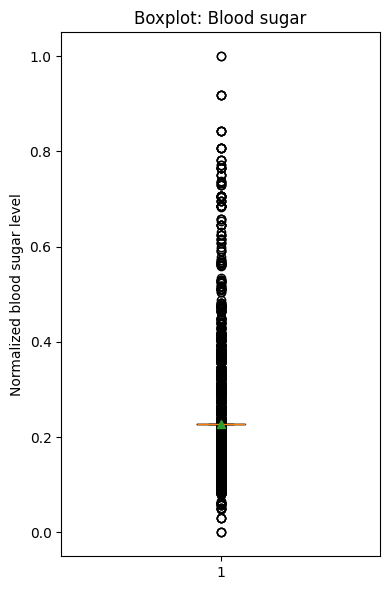


==== CK-MB ==== 

count    8442.000000
mean        0.047745
std         0.070399
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: CK-MB, dtype: float64 



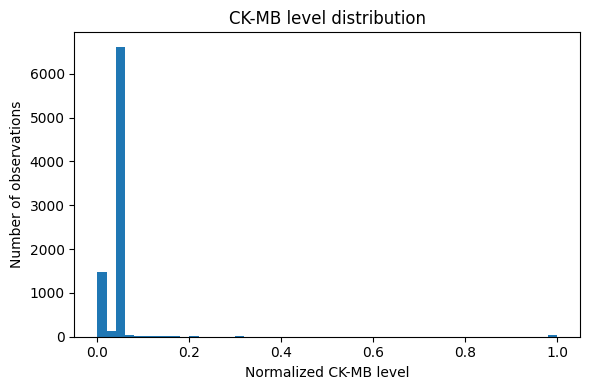

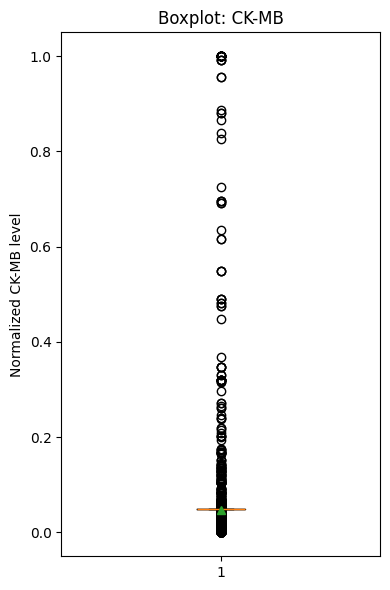


==== Troponin ==== 

count    8442.000000
mean        0.036867
std         0.059284
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: Troponin, dtype: float64 



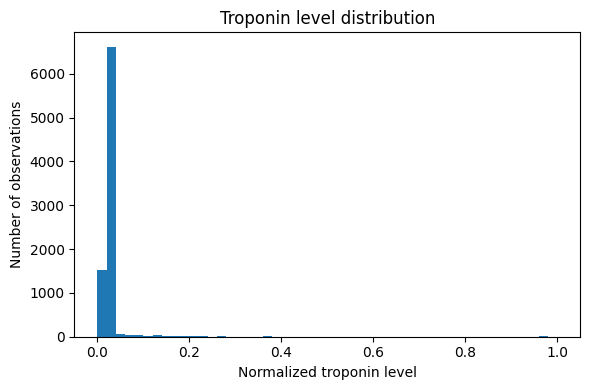

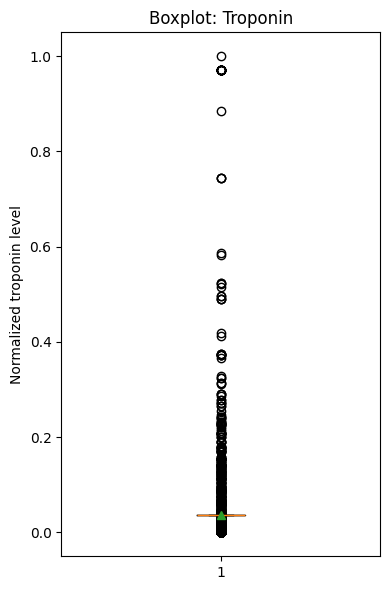


==== Gender ==== 

count     8442
unique       2
top       Male
freq      5882
Name: Gender, dtype: object 



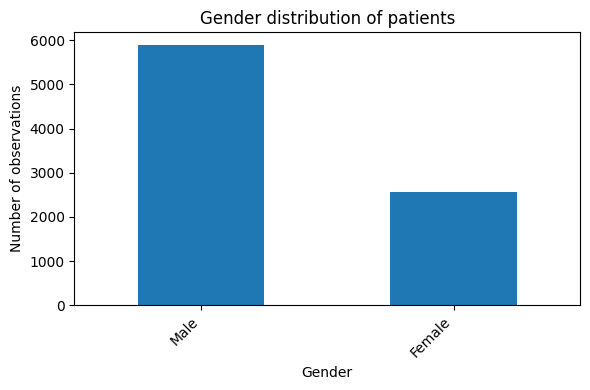

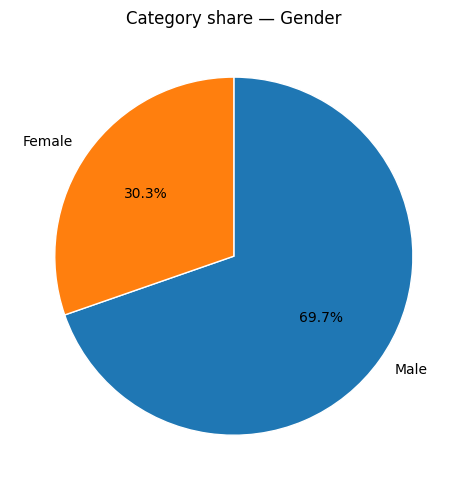


==== Systolic blood pressure ==== 

count    8442.000000
mean        0.451955
std         0.170187
min         0.161290
25%         0.303226
50%         0.451613
75%         0.600000
max         0.741935
Name: Systolic blood pressure, dtype: float64 



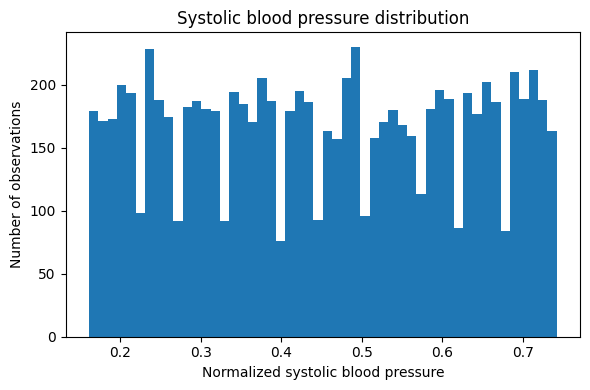

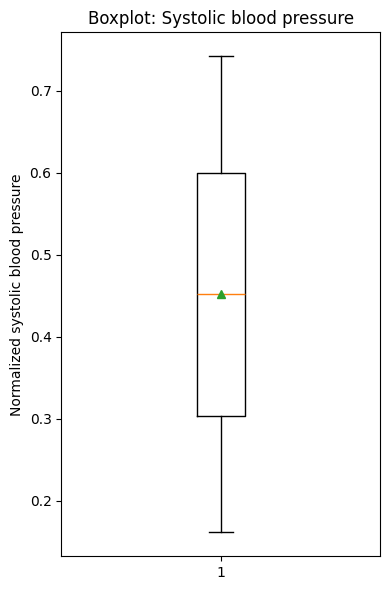


==== Diastolic blood pressure ==== 

count    8442.000000
mean        0.501672
std         0.170302
min         0.209302
25%         0.348837
50%         0.500000
75%         0.651163
max         0.790698
Name: Diastolic blood pressure, dtype: float64 



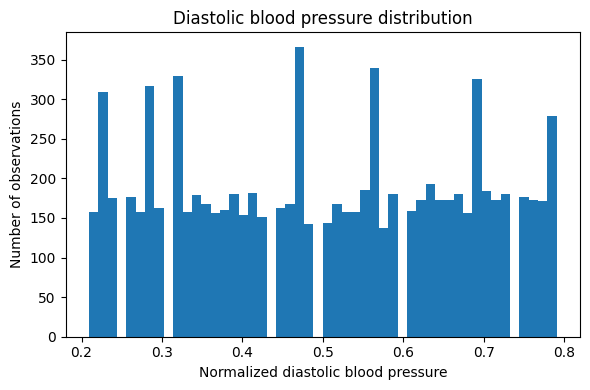

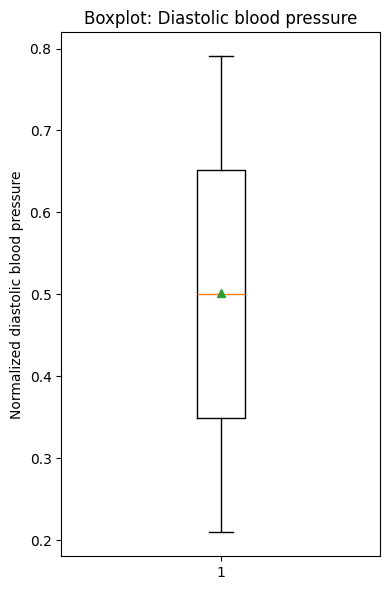

In [29]:
learn_data(df)

#### Conclusions from the Feature Distribution Analysis

* **Age**

Age is also presented on a normalized scale.

The distribution is close to symmetric; the median (≈ 0.46) and the mean (≈ 0.45) are almost identical.

The histogram shows that the data uniformly cover the value range, without concentration at the extremes.

The boxplot does not reveal extreme outliers.

**Conclusion:**
The *Age* feature is correctly represented, contains no anomalous values, and adequately reflects age variability in the dataset.


* **Cholesterol**

Values are distributed across the entire ([0, 1]) range, confirming prior normalization.

The mean and median are close (mean ≈ 0.50, median ≈ 0.50), and the distribution is close to uniform.

The boxplot shows a wide interquartile range, indicating high feature variability.

No obvious outliers are observed.

**Conclusion:**
*Cholesterol* is an informative continuous feature with good variability.


* **Heart rate**

The feature is presented in normalized form (values within a narrow range of approximately 0.018–0.082).

The mean (≈ 0.051) is almost identical to the median (≈ 0.050), indicating a symmetric distribution.

The histogram shows a fairly uniform distribution without pronounced skewness.

The boxplot does not reveal strong outliers — extreme values remain within reasonable bounds.

**Conclusion:**
The *Heart rate* feature is stable and does not contain anomalies or outliers.


* **Diabetes**

This is a binary feature.

A moderate class imbalance is observed:

~65% — diabetes present,
~35% — no diabetes.

**Conclusion:**
The feature is informative, but it is skewed toward the positive class. This distribution should be taken into account when interpreting model results.


* **Family History**

This is a binary feature.

The classes are distributed almost evenly:

~51% — no,
~49% — yes.

**Conclusion:**
*Family History* is a balanced and potentially important medical risk factor. It can be used directly in the model.


* **Smoking**

This is a binary feature.

A strong class imbalance is observed:

≈ 90% — smokers,
≈ 10% — non-smokers.

**Conclusion:**
The feature shows a pronounced imbalance, which may reduce its contribution to the model or lead to biased interpretation. This imbalance should be considered during model training (e.g., via class weighting or regularization).


* **Obesity**

This is a binary feature.

The distribution is almost perfectly balanced:

≈ 50% — obesity present,
≈ 50% — no obesity.

**Conclusion:**
*Obesity* is a high-quality binary feature without class bias. It is suitable for all types of models without additional adjustments.


* **Alcohol Consumption**

This is a binary feature: 0 — no, 1 — yes.

A moderate class imbalance is observed:

~60% — consume alcohol,
~40% — do not consume alcohol.

**Conclusion:**
The feature is informative and correctly encoded. The imbalance is not critical, but it can be taken into account when analyzing feature effects and interpreting the model.


* **Exercise Hours Per Week**

The feature is presented in normalized form.

The mean and median are close (≈ 0.50), indicating a symmetric distribution.

The boxplot does not show outliers.

The values are evenly distributed across the entire range.

**Conclusion:**
*Exercise Hours Per Week* is a stable continuous feature with high variability and no anomalies. It is suitable for use in models without additional cleaning.


* **Diet**

The feature takes 3 categories: 0, 1, 2.

The category distribution is nearly uniform:

each category ≈ 33%.

No clear class imbalance is observed.

**Conclusion:**
*Diet* is a well-formed categorical feature without bias toward any category. It can be used in the model without additional balancing methods.


- __Previous Heart Problems (Предыдущие сердечные проблемы)__

Бинарный признак.

Распределение практически симметрично:

~50% — были,

~50% — не было.

__Вывод:__
Признак сбалансирован и, с медицинской точки зрения, является одним из наиболее значимых факторов риска. Особенно важно проверить его влияние на целевую переменную.

* **Medication Use**

This is a binary feature (0 — no, 1 — yes).

The classes are almost perfectly balanced: ~50% / 50%.

The feature contains no missing values or anomalies.

**Conclusion:**
*Medication Use* is a correct and well-balanced binary feature. It can be directly used in models with minimal risk of bias.


* **Stress Level**

This is a discrete feature with values ranging from 1 to 10.

Frequencies across stress levels are approximately uniform.

There is no bias toward low or high values.

**Conclusion:**
*Stress Level* is a well-balanced feature. It is suitable for use either as a numerical or an ordinal variable.


* **Sedentary Hours Per Day**

This is a continuous, normalized feature.

The mean is approximately equal to the median, indicating a symmetric distribution.

No outliers are detected.

**Conclusion:**
The feature is correctly represented, logically complements physical activity, and may be informative when considered together with it.


* **Income**

This is a normalized numerical feature with a wide range of values.

The distribution is close to uniform.

The boxplot does not reveal outliers.

**Conclusion:**
The feature can be used directly, but its interpretability is limited.


* **BMI (Body Mass Index)**

This is a normalized continuous feature.

The mean and median are close (≈ 0.50), indicating a symmetric distribution.

No outliers or anomalous values are observed.

**Conclusion:**
*BMI* is correctly represented, raises no concerns, and is a potentially important medical risk factor.


* **Triglycerides**

This is a continuous feature normalized to the ([0, 1]) range.

The distribution is uniform, without pronounced skewness.

The boxplot does not show extreme outliers.

**Conclusion:**
*Triglycerides* is a stable continuous feature with good variability.


* **Physical Activity Days Per Week**

This is a discrete feature with values ranging from 0 to 7.

The distribution is nearly uniform across all days of the week.

The mean value is ≈ 3.5 days, and the median is 3.

**Conclusion:**
The feature is well balanced and does not require transformations. It is suitable for use as a discrete numerical feature.


* **Sleep Hours Per Day**

The feature is represented by discrete, normalized values corresponding to fixed sleep durations in hours.

The distribution is close to uniform, with no clear skew.

The mean is approximately equal to the median (≈ 0.50), and no outliers are observed.

**Conclusion:**
*Sleep Hours Per Day* is a correctly represented numerical feature with a limited number of possible values.


* **Blood Sugar**

  **Observations:**

  * A clear peak at a single point (around 0.23 on the normalized scale).
  * Values below and above this level occur much less frequently.

  **Boxplot and statistical analysis:**

  * The median, Q1, and Q3 coincide.
  * A long tail of high values with a large number of outliers.

**Interpretation:**

* Most observations effectively carry the same information.
* There may be a dependency on the *Diabetes* feature.

**Conclusion:**
In its current form, *Blood Sugar* has limited informativeness as a continuous feature.


* **CK-MB (Creatine Kinase–MB)**

  **Observations:**

  * The distribution is strongly right-skewed.
  * The vast majority of values are concentrated near zero.
  * A small number of observations take very high values (up to 1.0).

  **Boxplot and statistical analysis:**

  * The median, Q1, and Q3 coincide.
  * A large number of outliers are present.
  * The median is almost equal to the lower bound of the distribution.

**Interpretation:**

The feature exhibits extreme spikes.
In its current form, it:

* violates the assumption of normality,
* may dominate in linear models,
* strongly affects feature scaling.

**Conclusion:**
*CK-MB* should not be used in its raw form for most models.


* **Troponin**

  **Observations:**

  * The most extreme distribution among all features:

    * the overwhelming majority of values are close to zero,
    * only a few observations reach the maximum.

  **Boxplot and statistical analysis:**

  * a very large number of outliers,
  * the median is practically at zero,
  * the median, Q1, and Q3 coincide,
  * a long and sparse right tail,
  * the distribution is highly unstable.

**Conclusion:**
In its current form, *Troponin* has limited informativeness as a continuous feature.


* **Gender**

This is a categorical feature with two values: *Male* and *Female*.

A noticeable class imbalance is observed:

* Male ≈ 70%
* Female ≈ 30%

**Conclusion:**
Gender may contribute to risk prediction; however, the imbalance should be taken into account during analysis and modeling.


* **Systolic Blood Pressure**

This is also a normalized continuous feature.

The distribution is uniform, with no noticeable skew.

The boxplot does not reveal extreme outliers.

**Conclusion:**
*Systolic Blood Pressure* is correctly represented and informative.
Its correlation with *Diastolic Blood Pressure* should be examined.


* **Diastolic Blood Pressure**

This is a normalized continuous feature.

The distribution is close to symmetric.

The mean and median coincide (≈ 0.50).

No outliers are observed.

**Conclusion:**
*Diastolic Blood Pressure* is a stable physiological feature, correctly represented and ready for use without additional cleaning.


* **Heart Attack Risk (Binary) — target variable**

This is a binary target variable:
0 — low risk,
1 — high risk.

A moderate class imbalance is observed:

* class 0 ≈ 64%
* class 1 ≈ 36%

**Conclusion:**
The imbalance is present but not critical.
For model training, it is recommended to:

* use ROC-AUC and F1-score as evaluation metrics,
* apply `class_weight='balanced'` if necessary.


#### Correlation Analysis


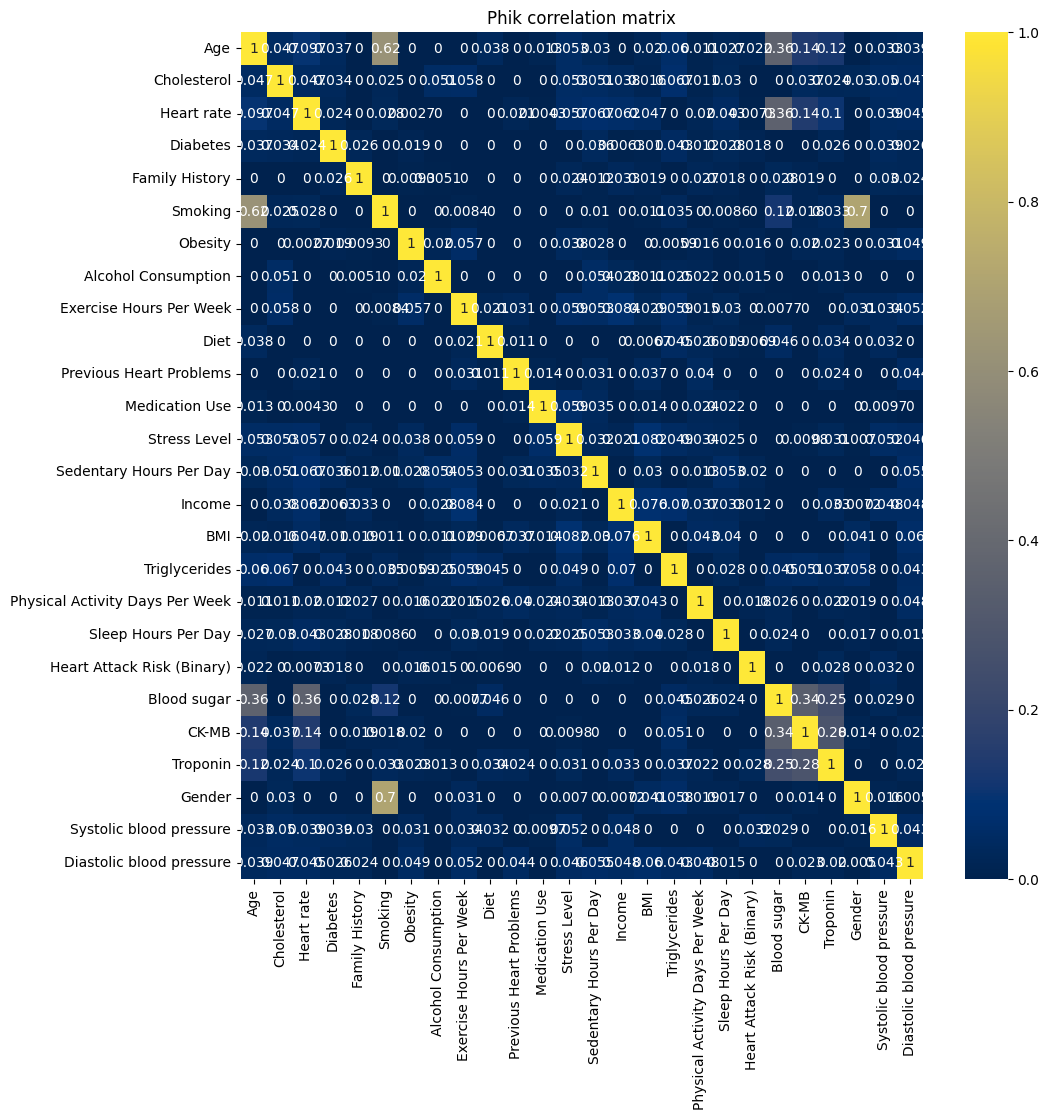

In [30]:
phik_corr = df.drop('id', axis=1).phik_matrix(interval_cols=continuous)
plt.figure(figsize=(11, 11))
sns.heatmap(phik_corr, annot=True, cmap="cividis")
plt.title("Phik correlation matrix")
plt.show()

In [31]:
display(phik_corr)

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
Age,1.000000,0.047296,0.096545,0.037166,0.000000,0.620530,0.000000,0.000000,0.000000,0.037997,...,0.059949,0.010839,0.027290,0.022225,0.359543,0.138603,0.122965,0.000000,0.033469,0.039000
Cholesterol,0.047296,1.000000,0.046766,0.033748,0.000000,0.025223,0.000000,0.051442,0.058412,0.000000,...,0.067432,0.010897,0.030416,0.000000,0.000000,0.037251,0.023634,0.029815,0.050402,0.046545
Heart rate,0.096545,0.046766,1.000000,0.023945,0.000000,0.027918,0.002655,0.000000,0.000000,0.000000,...,0.000000,0.020279,0.043306,0.007342,0.358178,0.141705,0.102284,0.000000,0.039319,0.044680
Diabetes,0.037166,0.033748,0.023945,1.000000,0.025809,0.000000,0.019436,0.000000,0.000000,0.000000,...,0.043154,0.012481,0.027584,0.018324,0.000000,0.000000,0.025830,0.000000,0.038714,0.026201
Family History,0.000000,0.000000,0.000000,0.025809,1.000000,0.000000,0.009305,0.005136,0.000000,0.000000,...,0.000000,0.027124,0.018189,0.000000,0.027865,0.018601,0.000000,0.000000,0.030289,0.024432
Smoking,0.620530,0.025223,0.027918,0.000000,0.000000,1.000000,0.000000,0.000000,0.008420,0.000000,...,0.034906,0.000000,0.008616,0.000000,0.115593,0.017989,0.032929,0.703385,0.000000,0.000000
Obesity,0.000000,0.000000,0.002655,0.019436,0.009305,0.000000,1.000000,0.020462,0.057019,0.000000,...,0.005890,0.016269,0.000000,0.015839,0.000000,0.019953,0.022984,0.000000,0.031370,0.049056
Alcohol Consumption,0.000000,0.051442,0.000000,0.000000,0.005136,0.000000,0.020462,1.000000,0.000000,0.000000,...,0.025038,0.021965,0.000000,0.014553,0.000000,0.000000,0.012937,0.000000,0.000000,0.000000
Exercise Hours Per Week,0.000000,0.058412,0.000000,0.000000,0.000000,0.008420,0.057019,0.000000,1.000000,0.020915,...,0.058767,0.015356,0.029830,0.000000,0.007701,0.000000,0.000000,0.031349,0.034355,0.052272
Diet,0.037997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020915,1.000000,...,0.044896,0.025646,0.018720,0.006872,0.046313,0.000000,0.033751,0.000000,0.031896,0.000000


##### General Conclusions from the Phik Correlation Matrix

* **Gender ↔ Smoking ≈ 0.70** — a strong relationship; this feature reflects gender differences in smoking behavior.

* **Age ↔ Smoking ≈ 0.62** — a high correlation.

* For most feature pairs, correlations are weak or close to zero.

* No strong linear or nonlinear dependencies between features were identified. This indicates the absence of pronounced multicollinearity in the data.

* Overall, the features are largely independent of each other.

**The dataset shows weak correlations with the target variable, which suggests:**

* a nonlinear nature of the relationships,
* threshold effects,
* or synthetic data generation.

**This implies that:**

* linear models may perform poorly,
* tree-based models and boosting methods are preferable,
* correlation should not be used as a primary criterion for feature selection.


#### Final EDA Summary

* **1. Overall data characteristics**

During the analysis, a dataset of **8,442 observations and 27 features** (**after cleaning**) was examined.
The target variable is **Heart Attack Risk (Binary)**, a binary label with a moderate class imbalance (≈36% positive class).

Most features are represented on a **normalized [0, 1] scale**, indicating that the data were preprocessed prior to the modeling stage.

* **2. Data quality and cleaning**

- No explicit duplicates were found.
- A **systematic missing-value issue** was identified in 243 rows, characterized by:

  * binary encoding of gender (`Gender = '0.0' / '1.0'`),
  * simultaneous missing values across an entire block of medical and behavioral features,
  * constant values in several numerical columns.

These rows were interpreted as **corrupted or technically invalid records** and were **removed**, since imputing them would have resulted in artificially generated observations.

After removal, the dataset contains **no NaN values**, allowing it to be used directly for model training.

* **3. Feature structure and types**

Features were correctly divided into groups:

* **Binary** (Diabetes, Smoking, Obesity, etc.) — values {0,1}, no encoding errors.
* **Categorical** — `Gender` (Male/Female), `Diet` (3 categories).
* **Discrete numerical** — `Stress Level`, `Physical Activity Days Per Week`, `Sleep Hours Per Day`.
* **Continuous** — age, blood pressure, BMI, biochemical markers, etc.

Most features show **adequate variability**, symmetric distributions, and no anomalous outliers.

* **4. Characteristics of individual features**

  * **Stable and well-behaved features**

    Age, cholesterol, heart rate, blood pressure, BMI, triglycerides, physical activity, and sleep:

    * are evenly distributed,
    * contain no extreme outliers,
    * are suitable for use without additional cleaning.

  * **Binary behavioral and medical features**

    Generally correct; however:

    * `Smoking` and `Gender` show a strong association,
    * some features exhibit class imbalance, which should be considered during modeling.

  * **Biochemical markers (Blood Sugar, CK-MB, Troponin)**

    **Atypical distributions** were observed:

    * strong concentration of values at a single point,
    * identical medians and quartiles,
    * long tails with rare extreme values.

    This indicates **limited informativeness of these features under linear assumptions** and suggests possible threshold or nonlinear effects.
    In their raw form, these features are **not recommended for linear models**, but may be useful for decision trees and ensemble methods.

* **5. Correlation analysis**

The Phik correlation matrix showed:

* no strong multicollinearity among most features,
* pronounced relationships:

  * `Gender ↔ Smoking`,
  * `Age ↔ Smoking`.

Correlations with the target variable are generally **weak**, suggesting:

* nonlinear relationships,
* possible threshold effects,
* or a synthetic nature of the data.

- **6. General conclusions**

1. **After cleaning, the data are structurally sound and suitable for modeling.**
2. Missing-value imputation was deliberately avoided, as the missingness was technical rather than random.
3. Correlation should not be used as the primary criterion for feature selection.
4. Linear models may exhibit limited performance.
5. **Most suitable model families:**

   * Random Forest,
   * Gradient Boosting (XGBoost / LightGBM / CatBoost),
     as they are able to:
   * capture nonlinearities,
   * automatically detect thresholds,
   * remain robust to skewed feature distributions.


#### Model Selection for Subsequent Modeling

The results of the exploratory data analysis showed that the dataset has several characteristics that directly influence the choice of suitable machine-learning models:

* most features exhibit **nonlinear or threshold effects**;
* correlations between features and the target variable are generally weak;
* biochemical markers (*Blood Sugar*, *CK-MB*, *Troponin*) have **skewed distributions with extreme values**;
* assumptions of distribution normality are **generally not satisfied**.

Given these properties, priority was given to algorithms that can effectively handle such data.

---

**Tree-based models (preferred choice)**

* Random Forest
* Gradient Boosting (XGBoost / LightGBM / CatBoost)

**Why these models are best suited**

Tree-based algorithms possess several critical properties that align well with the data structure:

1. **Automatic threshold detection**
   The models independently split the feature space, which is especially important for features with pronounced threshold effects (e.g., *Blood Sugar*).

2. **Robustness to outliers**
   Extreme values (*CK-MB*, *Troponin*) do not dominate the model, since decisions are based on local splits rather than global coefficients.

3. **Ability to model nonlinear relationships**
   Including U-shaped and piecewise-linear effects that cannot be adequately captured by linear models.

4. **No strict distributional assumptions**
   Normality, symmetry, or linearity are not required, which is particularly important for real-world medical data.

**Practical implication**

For tree-based models, the features *Blood Sugar*, *CK-MB*, and *Troponin* **can be used in their raw form**, without manual transformations or aggressive threshold engineering.

---

**Linear models (not recommended without transformations)**

**Key limitations**

Linear models are poorly aligned with the observed data characteristics:

1. **Linearity assumption**
   Most features do not demonstrate a linear relationship with the target variable.

2. **Sensitivity to outliers**
   Extreme values in biochemical markers may dominate and distort the model.

3. **Inability to capture U-shaped relationships**
   Without manual nonlinear feature engineering, such effects are entirely lost.

For linear models, **feature transformations are mandatory** (log transformations, binarization, threshold engineering). Otherwise, their use leads to methodologically incorrect results.

---

**Final conclusion**

Considering the data structure, distribution characteristics, and correlation analysis results, **tree-based models represent the most justified and reliable choice** for this task. They allow the use of raw features without aggressive preprocessing and better capture the complex nature of medical risk factors.


## Model Training and Evaluation


### Data Preparation


For correct operation of the CatBoost model, categorical features were converted to string type.


In [32]:
# preparing the data
df['Diet'] = df['Diet'].astype(str)
df['Gender'] = df['Gender'].astype(str)
cat_features = ['Gender', 'Diet']

X = df.drop(['id', 'Heart Attack Risk (Binary)'], axis=1)
y = df['Heart Attack Risk (Binary)']


**Feature encoding considerations for tree-based models**

Within this study, feature encoding was chosen with regard to the selected model family:

* **Binary features** (Diabetes, Smoking, Obesity, etc.) are already represented in numerical form {0, 1} and do not require additional encoding.

* **Categorical features** (Gender, Diet) can be used directly in models that support categorical variables (e.g., CatBoost).

* **Continuous and discrete numerical features** are used in their original form without normalization or scaling, since the features are already brought to a common scale.

Thus, for tree-based models—especially CatBoost—there is no need to apply **One-Hot Encoding**, **Ordinal Encoding**, or similar techniques. This reduces the risk of introducing artificial ordering into the data and simplifies the training pipeline.


### Training the CatBoostClassifier Model


The **CatBoostClassifier** model was selected for training as a representative of gradient boosting, well suited for problems with:

* nonlinear effects,
* threshold-based relationships,
* mixed data types (numerical + categorical),
* violations of normality assumptions.

**Model parameters:**

* `iterations=2000`, `learning_rate=0.03`, `depth=11` — control model complexity and training speed;
* `auto_class_weights='Balanced'` — automatically compensates for class imbalance;
* `early_stopping_rounds=200` — stops training if the validation metric does not improve, helping to prevent overfitting;
* `eval_metric='AUC'` — the primary quality metric evaluated on the validation set.


**Justification for choosing ROC-AUC as the evaluation metric**

ROC-AUC was selected as the primary performance metric because the task involves class imbalance and requires assessing the model’s ability to identify high-risk cases.

ROC-AUC evaluates the quality of **probability ranking**, rather than performance at a fixed classification threshold. This is especially important for medical applications, where the model is used as a risk assessment tool. The metric is threshold-independent and allows for fair comparison of models and hyperparameters during training.

In addition, ROC-AUC captures the trade-off between correctly identifying high-risk cases and the number of false positives, making it a methodologically sound choice for this problem.


#### Model Evaluation Using Stratified K-Fold

To assess the robustness and generalization ability of the model, **stratified k-fold cross-validation (k = 5)** was applied. This approach allowed us to:

* preserve class proportions in each fold;
* evaluate the stability of model performance across different data subsets;
* avoid dependence on a single random train–test split.


In [33]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

auc_scores = []
f1_scores = []
best_thresholds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.03,
        depth=8,
        eval_metric='AUC',
        random_seed=RANDOM_STATE,
        verbose=0,
        auto_class_weights='Balanced',
        early_stopping_rounds=200
    )

    model.fit(
        X_train, y_train,
        cat_features=cat_features,
        eval_set=(X_val, y_val),
        use_best_model=True
    )

    proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, proba)

    thresholds_range = np.linspace(0.05, 0.95, 50)
    f1s = [f1_score(y_val, (proba >= t).astype(int)) for t in thresholds_range]
    best_t = thresholds_range[int(np.argmax(f1s))]

    pred = (proba >= best_t).astype(int)
    f1 = max(f1s)

    auc_scores.append(auc)
    f1_scores.append(f1)
    best_thresholds.append(best_t)

    print(f"Fold {fold}: AUC={auc:.3f}, F1={f1:.3f},  best_threshold = {best_t:.3f}")

print("\nMean AUC:", np.mean(auc_scores), "Std:", np.std(auc_scores))
print("Mean F1:", np.mean(f1_scores), "Std:", np.std(f1_scores))
print("Mean best threshold:", np.mean(best_thresholds), "Std:", np.std(best_thresholds))

Fold 1: AUC=0.567, F1=0.532,  best_threshold = 0.417
Fold 2: AUC=0.543, F1=0.529,  best_threshold = 0.491
Fold 3: AUC=0.564, F1=0.531,  best_threshold = 0.307
Fold 4: AUC=0.562, F1=0.531,  best_threshold = 0.234
Fold 5: AUC=0.574, F1=0.535,  best_threshold = 0.362

Mean AUC: 0.5620500345380559 Std: 0.010227663047583794
Mean F1: 0.5317725621979514 Std: 0.001913352807552236
Mean best threshold: 0.36224489795918363 Std: 0.08846885812990257


**Average results:**

* Mean ROC-AUC ≈ 0.56, Std ≈ 0.01
* Mean F1 ≈ 0.53, Std ≈ 0.002
* Mean best threshold ≈ 0.36, Std ≈ 0.088

The small standard deviation values indicate **model robustness and stable performance** across folds.

The optimal classification threshold that maximizes the F1-score varies between folds, reflecting the sensitivity of this metric to the distribution of predicted probabilities. As the final classification threshold, an aggregated value was selected:

* **Mean best threshold ≈ 0.36**

This threshold provides a balanced trade-off between recall and precision when identifying patients at high risk.


#### Final Training


After confirming the model’s stability, a final **train–test split** was performed while preserving class proportions. The model was trained on the training set and evaluated on the held-out test set.


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['id', 'Heart Attack Risk (Binary)'], axis=1),
    df['Heart Attack Risk (Binary)'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['Heart Attack Risk (Binary)']
)

print("Dataset shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Dataset shapes:
X_train: (6331, 25)
X_test: (2111, 25)
y_train: (6331,)
y_test: (2111,)


In [35]:
cb_model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=11,
    eval_metric='AUC',
    random_seed=RANDOM_STATE,
    verbose=200,
    auto_class_weights='Balanced',
    early_stopping_rounds=200
)
# Fit
cb_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)

0:	test: 0.5251327	best: 0.5251327 (0)	total: 230ms	remaining: 7m 40s
200:	test: 0.5860710	best: 0.5862079 (199)	total: 30.1s	remaining: 4m 29s
400:	test: 0.5848926	best: 0.5865766 (216)	total: 1m 3s	remaining: 4m 14s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5865766194
bestIteration = 216

Shrink model to first 217 iterations.


**Best test AUC ≈ 0.59**

This means the model distinguishes the classes better than random guessing (0.5), but the overall performance is still moderate.


#### ROC curve

**ROC curve**

The ROC curve illustrates the trade-off between:

* **TPR (Recall)** — the proportion of correctly identified positive cases (“1”);
* **FPR** — the proportion of false alarms among negative cases (“0”).


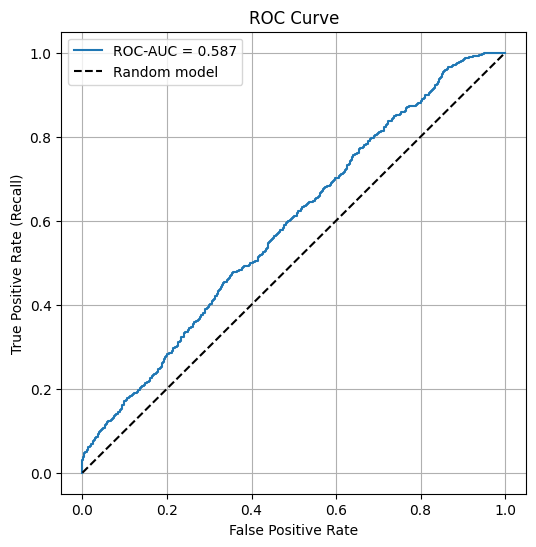

In [36]:
# ROC curve
proba = cb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random model")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#### F1 Score

For the final model, the threshold obtained during the cross-validation stage was used.

In [37]:
pred = (proba >= np.mean(best_thresholds)).astype(int)

print("Best threshold:", np.mean(best_thresholds))
print("F1:", max(f1s))

Best threshold: 0.36224489795918363
F1: 0.5350749879051766


**Result:**

* **F1 (for class 1) ≈ 0.54**

**What F1 optimization means**

F1 represents a balance between **precision** and **recall** for class 1.
With this threshold selection, the model starts to **prioritize protecting class 1** (i.e., not missing high-risk cases), even if this leads to an increase in false alarms.

This trade-off is acceptable because the primary goal is:

**It is better to issue an extra warning about risk than to miss a patient with high risk.**


#### Classification report и Confusion Matrix

In [38]:
print(classification_report(y_test, pred))
print("Confusion matrix:\n", confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.75      0.28      0.41      1358
         1.0       0.39      0.83      0.53       753

    accuracy                           0.48      2111
   macro avg       0.57      0.55      0.47      2111
weighted avg       0.62      0.48      0.45      2111

Confusion matrix:
 [[379 979]
 [128 625]]


**Conclusion on the metrics**

The F1-optimized threshold indeed demonstrates the model’s ability to detect class 1 (high risk), while also making the model more “alert,” resulting in a higher number of false positives.

Optimizing F1 leads to a strategy in which the model prefers **not to miss patients at high risk**, even at the cost of increased false alarms. In the context of a medical task, such a strategy is justified.


#### Feature Importance Analysis (CatBoost)

In [39]:
cb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,BMI,6.818368
1,Systolic blood pressure,6.780396
2,Cholesterol,6.673463
3,Sedentary Hours Per Day,6.661196
4,Heart rate,6.632672
5,Triglycerides,6.583891
6,Sleep Hours Per Day,6.488686
7,Stress Level,6.257707
8,Income,6.211900
9,Age,6.111825


**Key conclusions from feature importance analysis (CatBoost):**

* **The largest contribution** to the model comes from **continuous physiological and behavioral features**: BMI, blood pressure, cholesterol, heart rate, triglycerides, physical activity, and sleep. Their importance values lie in a similar range, indicating a **distributed effect rather than dominance of a single factor**.

* **Age and lifestyle indicators** (sedentary time, physical activity, stress) are also among the key predictors, confirming the **multifactorial nature of cardiovascular risk**.

* **Classical binary medical factors** (diabetes, family history, obesity, medication use) show a **moderate contribution**, being less informative than continuous measurements.

* **Biochemical markers** (CK-MB, Troponin, Blood Sugar) demonstrate **low importance**, which is consistent with their skewed distributions and possible threshold effects.

* **Categorical features** (Gender, Diet, Smoking) have **minimal contribution**, suggesting a secondary role in this model compared to physiological indicators.

**Overall conclusion:**
The model relies primarily on a **combination of continuous clinical and behavioral features**, rather than on individual binary or demographic factors. This further supports the appropriateness of **tree-based methods** for this task.


### Final Conclusions on Modeling

* The **CatBoostClassifier** model was trained correctly; the use of early stopping effectively controlled overfitting.

* The results of **Stratified K-Fold cross-validation** demonstrate model robustness and low metric variability, confirming the stability of the chosen configuration.

* A **ROC-AUC ≈ 0.59** indicates a moderate ability of the model to distinguish between classes.

* Optimizing the classification threshold based on the F1-score allows the model to almost never miss high-risk patients, but leads to an increase in false-positive predictions.

* The resulting optimal threshold (**≈ 0.36**) corresponds to a strategy aimed at minimizing missed high-risk patients, even at the cost of more false alarms, which is acceptable in a medical context.

* Feature importance analysis shows that the model primarily relies on **continuous clinical and behavioral indicators**, further supporting the appropriateness of **tree-based methods** for this task.

---


## Additional: Model Application Logic in an Application


This section describes the logic for applying the trained model in a practical application and the specifics of handling invalid or corrupted observations at the prediction stage.


### Model Application Logic and Handling Missing Values

The prediction quality check script requires a result **for every `id`** in the test set, including rows with missing values.

At the same time, the trained model operates correctly **only on fully populated data**, and imputing missing medical features is methodologically incorrect.

Therefore, the following logic is applied at the model inference stage:

* for rows **without missing values**, standard model prediction is performed;
* for rows **with missing values**, a fallback strategy is applied by assigning `prediction = 0`;
* predictions are generated **for all `id` values**, ensuring compliance with the requirements of the validation script;
* the identifiers of rows for which the fallback rule was applied are **saved to a separate file** to ensure transparency and enable further analysis.

The end-to-end experiment conducted below showed that using the fallback strategy does **not lead to a significant degradation of quality metrics** (F1-score ≈ 0.53) compared to results obtained on the cleaned dataset.


**We take the raw dataset and extract the rows containing NaN values**


In [40]:
df_raw = pd.read_csv("../data/heart_train.csv")

df_raw = df_raw.drop(columns=["Unnamed: 0"], errors="ignore")

X_raw = df_raw.drop(columns=["id", "Heart Attack Risk (Binary)"])
y_raw = df_raw["Heart Attack Risk (Binary)"]

# categorical features — same handling as in the model
X_raw["Gender"] = X_raw["Gender"].astype(str)
X_raw["Diet"] = X_raw["Diet"].astype(str)

# rows containing NaN values
nan_mask = X_raw.isna().any(axis=1)

X_nan = X_raw.loc[nan_mask]
y_nan = y_raw.loc[nan_mask]

print("NaN rows:", len(X_nan))


NaN rows: 243


**Merging `X_test` with the NaN rows**

In [41]:
X_test_ext = pd.concat([X_test, X_nan], axis=0)
y_test_ext = pd.concat([y_test, y_nan], axis=0)

print("X_test clean:", len(X_test))
print("X_test + NaN:", len(X_test_ext))

X_test clean: 2111
X_test + NaN: 2354


**Prediction logic: clean rows → model prediction, NaN rows → fallback = 0**

In [42]:
# mask for clean rows (no missing values)
clean_mask = ~X_test_ext.isna().any(axis=1)

# initialize fallback = 0 for all rows
proba_full = np.zeros(len(X_test_ext))

# model prediction — ONLY for clean rows
proba_clean = cb_model.predict_proba(
    X_test_ext.loc[clean_mask]
)[:, 1]

# fill probabilities for clean rows
proba_full[clean_mask.values] = proba_clean

# use the threshold obtained from cross-validation
threshold = float(np.mean(best_thresholds))
pred_full = (proba_full >= threshold).astype(int)

print("F1 (end-to-end, fallback=0):", f1_score(y_test_ext, pred_full))
print(classification_report(y_test_ext, pred_full))
print("Confusion matrix:\n", confusion_matrix(y_test_ext, pred_full))


F1 (end-to-end, fallback=0): 0.5303351718285957
              precision    recall  f1-score   support

         0.0       0.83      0.39      0.53      1601
         1.0       0.39      0.83      0.53       753

    accuracy                           0.53      2354
   macro avg       0.61      0.61      0.53      2354
weighted avg       0.69      0.53      0.53      2354

Confusion matrix:
 [[622 979]
 [128 625]]


**The end-to-end experiment demonstrated that applying the fallback strategy does not lead to a significant degradation in quality metrics (F1-score ≈ 0.53) compared to the results on the cleaned dataset.**


* The model is trained and validated **only on clean, valid data**.
* For records with missing values, a **deterministic fallback rule** is applied (`prediction = 0`).
* End-to-end metrics are computed **with this rule taken into account**, matching the system’s production behavior.


**Thus, the chosen logic ensures correct and reproducible operation of the model.**
